In [4]:
import gc

import re

import pandas as pd
#import modin.pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from cycler import cycler

import multiprocessing as mp

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity
#unit_parser = np.vectorize(lambda x : Q_(x).to_base_units().magnitude)

In [5]:
def parse_if_number(s):
    try: 
        return float(s)
    except: 
        try:
            return Q_(s).to_base_units().magnitude
        except:
            return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    result = None
    
    if s:
        return np.fromstring(s, sep=' ')
    else:
        return None

def parse_string(s):
    if s:
        return s
    else:
        return None

class LazyEval:
    
    def __init__(self, evalFunc, s):
        self.evalFunc = evalFunc
        self.s = s
        self.value = None
    
    def evaluate(self):
        if self.value is None:
            self.value = self.evalFunc(self.s)
        
        return self.value

In [6]:
select_columns = ['run', 'type', 'module', 'name', 'attrname', 'attrvalue', 'value', 'vectime', 'vecvalue']
out_columns = select_columns

runs = 10
samplingRate = 100
queueSize = 6

def reduce_hist(x):
    result = np.add.reduce(x.values) / x.size
    result /= np.add.reduce(result)
    
    return result.tolist()

def filter_chunk(chunk):
    cvars = chunk.loc[
        (chunk.type == 'itervar') 
        | (chunk.type == 'runattr') 
        | (chunk.type == 'scalar'), 
        select_columns]
    # add created columns to enable frictionless concat
    #cvars['hist'] = None
    vectors = chunk[(chunk.type == 'vector') 
                    #& ((chunk.name == 'ctrlTargetQM:vector') # end host target QM
                    & ((chunk.name == 'coccAppliedQM:vector') # end host target QM
                       |(chunk.name == 'act_delay_ca:vector') # end host e2e delay
                       |((chunk.module.str.startswith('FourHopNcs.ncs')) 
                         & (chunk.name == 'ppp0-bitrate:vector')) # end host bitrate
                       |(chunk.module.str.startswith('FourHopNcs.ic1') #ic1 queue
                        &(chunk.name.str.contains(r'ppp0-(?:ctrlL)?BE-qLength:vector')))
                       |(chunk.module.str.contains('FourHopNcs.ic[23]') #ic2,3 queue
                        &(chunk.name.str.contains(r'ppp1-(?:ctrlL)?BE-qLength:vector')))
                      )]
    rows = []
    
    for row in vectors.itertuples():
        name = None
        value = None
        
        masked_vecvalue = np.ma.array(
            row.vecvalue.evaluate(), 
            mask=(row.vectime.evaluate() < 30)
        ).compressed()
        
        if row.name == 'coccAppliedQM:vector':#'ctrlTargetQM:vector':
            name = 'ctrlTargetQM'
            value = masked_vecvalue
        if row.name == 'act_delay_ca:vector':
            name = 'act_delay_ca'
            value = masked_vecvalue
        if row.name == 'ppp0-bitrate:vector':
            name = 'ctrlBitrate'
            value = masked_vecvalue
        if re.search(r'ppp[01]-BE-qLength:vector', row.name):
            name = 'bnBEQueue'
            value = masked_vecvalue
        if re.search(r'ppp[01]-ctrlLBE-qLength:vector', row.name):
            name = 'bnLBEQueue'
            value = masked_vecvalue

        r_new = [ 
            row.run, 
            row.type, 
            row.module, 
            name, 
            row.attrname,
            row.attrvalue,
            value,
            row.vectime.evaluate(),
            row.vecvalue.evaluate()
        ]
        rows.append(r_new)
            
    result = pd.concat([cvars, pd.DataFrame(data=rows, columns=out_columns)])
    
    return(result)

In [7]:
csv_prefix = '../results-fourhop/'

iterator = pd.read_csv(csv_prefix + 'MultiBottleneck_Mock_4FlowsCross.csv.xz', chunksize=20, converters = {
    'attrname' : parse_string,
    'attrvalue': parse_if_number,
    'binedges': lambda x : LazyEval(parse_ndarray, x),
    'binvalues': lambda x : LazyEval(parse_ndarray, x),
    'module' : parse_string,
    'name' : parse_string,
    'vectime': lambda x : LazyEval(parse_ndarray, x),
    'vecvalue': lambda x : LazyEval(parse_ndarray, x)})

data_chunks = []
pool = mp.Pool(processes=2)

print('reading data in chunks')

for chunk in iterator:
    chunk_result = pool.apply_async(filter_chunk, [chunk])
    #chunk_result = filter_chunk(chunk)
    data_chunks.append(chunk_result)

pool.close()
pool.join()

print('concatenating chunked data')

data = pd.concat((chunk.get() for chunk in data_chunks), ignore_index=True)
#data = pd.concat((chunk for chunk in data_chunks), ignore_index=True)

#display(data)
display(data.head())
display(data.tail())

reading data in chunks
concatenating chunked data


,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
0,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,runattr,None,None,configname,MultiBottleneck_Mock_4FlowsCross,NaN,<__main__.LazyEval object at 0x7f6ffd1bda58>,<__main__.LazyEval object at 0x7f6ffd1bdeb8>
1,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,runattr,None,None,datetime,20210721,NaN,<__main__.LazyEval object at 0x7f6ffd1bda90>,<__main__.LazyEval object at 0x7f6ffd1bdef0>
2,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,runattr,None,None,experiment,MultiBottleneck_Mock_4FlowsCross,NaN,<__main__.LazyEval object at 0x7f6ffd1bdac8>,<__main__.LazyEval object at 0x7f6ffd1bdf28>
3,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,runattr,None,None,inifile,/mnt/data/Projekte/SPP1914_CPN/code/ncs-testbe...,NaN,<__main__.LazyEval object at 0x7f6ffd1bdb00>,<__main__.LazyEval object at 0x7f6ffd1bdf60>
4,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,runattr,None,None,iterationvars,"$ccMode=1, $collectionInterval=0.05, $bottlene...",NaN,<__main__.LazyEval object at 0x7f6ffd1bdb38>,<__main__.LazyEval object at 0x7f6ffd1bdf98>


,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
558,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs12[0].ncsContext,act_delay_ca,None,None,"[0.000799281916, 0.0003493, 0.000422853968, 0....","[32.0051993, 32.009549337812, 32.0116229, 32.0...","[0.000799281916, 0.0003493, 0.000422853968, 0...."
559,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs23[0].controller.coCC,ctrlTargetQM,None,None,"[0.0, 0.47861402872519, 0.47705271135325, 0.64...","[33.96, 34.01, 34.06, 34.11, 34.16, 34.21, 34....","[0.0, 0.47861402872519, 0.47705271135325, 0.64..."
560,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs23[0].ncsContext,act_delay_ca,None,None,"[0.000394246798, 0.000469134214, 0.00046848101...","[34.0019657, 34.0037549, 34.0053257, 34.007009...","[0.000394246798, 0.000469134214, 0.00046848101..."
561,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs34[0].controller.coCC,ctrlTargetQM,None,None,"[0.0, 0.49465363618078, 0.49086685998547, 0.49...","[35.96, 36.01, 36.06, 36.11, 36.16, 36.21, 36....","[0.0, 0.49465363618078, 0.49086685998547, 0.49..."
562,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs34[0].ncsContext,act_delay_ca,None,None,"[0.00040583462, 0.000385302476, 0.000364770332...","[36.001739166764, 36.003051966764, 36.00436476...","[0.00040583462, 0.000385302476, 0.000364770332..."


In [8]:
scalars = data[data.type=='scalar']
vectors = data[data.type=='vector']

print(len(scalars))
len(vectors)

524


18

In [9]:
%xdel -n data
data = None

gc.collect()

6857

In [10]:
scalars.head()
vectors.head()

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
545,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ic3.monitoringCollector,bnBEQueue,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
546,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs12[0].controller.monitoringColle...,ctrlBitrate,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
547,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs14[0].controller.monitoringColle...,ctrlBitrate,None,None,"[12640.0, 10945440.0, 13506240.0, 12807840.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
548,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs23[0].controller.monitoringColle...,ctrlBitrate,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
549,MultiBottleneck_Mock_4FlowsCross-0-20210721-10...,vector,FourHopNcs.ncs34[0].controller.monitoringColle...,ctrlBitrate,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
#for col in vectors.columns:
#    print(col)
scalars.name.unique(), vectors.name.unique(), vectors.module.unique()

(array(['dropPk:count', 'dropPk:sum(packetBytes)', 'queueLength:max',
        'queueLength:timeavg', 'rcvdPk:count', 'rcvdPk:sum(packetBytes)',
        'txState:timeavg', 'droppedPkIfaceDown:count',
        'droppedPkIfaceDown:sum(packetBytes)', 'droppedPkBitError:count',
        'droppedPkBitError:sum(packetBytes)', 'rxPkOk:count',
        'rxPkOk:sum(packetBytes)', 'txPk:count', 'txPk:sum(packetBytes)',
        'rcvdPkFromHL:count', 'rcvdPkFromHL:sum(packetBytes)',
        'passedUpPk:count', 'passedUpPk:sum(packetBytes)'], dtype=object),
 array(['bnBEQueue', 'ctrlBitrate', 'act_delay_ca', 'ctrlTargetQM',
        'bnLBEQueue'], dtype=object),
 array(['FourHopNcs.ic3.monitoringCollector',
        'FourHopNcs.ncs12[0].controller.monitoringCollector',
        'FourHopNcs.ncs14[0].controller.monitoringCollector',
        'FourHopNcs.ncs23[0].controller.monitoringCollector',
        'FourHopNcs.ncs34[0].controller.monitoringCollector',
        'FourHopNcs.ic1.monitoringCollector',
       

In [12]:
time_series_qm = pd.DataFrame()
time_series_rate = pd.DataFrame()
time_series_delay = pd.DataFrame()
time_series_queue = pd.DataFrame()

hop_list = ["ncs12","ncs23","ncs34","ncs14"]
ic_list = ["ic1","ic2","ic3"]
module_list = hop_list + ic_list
name_list = vectors.name.unique()

for row in vectors.itertuples():
    rowGroup = None
    for candidate in module_list:
        if re.search(candidate, row.module):
            rowGroup = candidate
    if rowGroup is None:
        print("WARNING: unable to match " + row.module)
    
    rowFrame = pd.DataFrame(
        {(rowGroup, row.name) : row.vecvalue}, 
        index=row.vectime,
        columns=[(rowGroup, row.name)]
    )
    rowFrame = rowFrame[(rowFrame.index >= 30)]
    
    if row.name == 'ctrlTargetQM': #by hop
        time_series_qm = time_series_qm.join(rowFrame, how='outer')
    if row.name == 'ctrlBitrate': #by hop
        time_series_rate = time_series_rate.join(rowFrame, how='outer')
    if row.name == 'act_delay_ca': #by hop
        time_series_delay = time_series_delay.join(rowFrame, how='outer')
    if row.name == 'bnBEQueue': #by ic
        time_series_queue = time_series_queue.join(rowFrame, how='outer')
    if row.name == 'bnLBEQueue': #by ic
        time_series_queue = time_series_queue.join(rowFrame, how='outer')
        
time_series_qm = time_series_qm.reindex(sorted(time_series_qm.columns), axis=1)
time_series_rate = time_series_rate.reindex(sorted(time_series_rate.columns), axis=1)
time_series_delay = time_series_delay.reindex(sorted(time_series_delay.columns), axis=1)
time_series_queue = time_series_queue.reindex(sorted(time_series_queue.columns), axis=1)

time_series_qm.columns = pd.MultiIndex.from_tuples(time_series_qm.columns, names=["group", "name"])
time_series_rate.columns = pd.MultiIndex.from_tuples(time_series_rate.columns, names=["group", "name"])
time_series_delay.columns = pd.MultiIndex.from_tuples(time_series_delay.columns, names=["group", "name"])
time_series_queue.columns = pd.MultiIndex.from_tuples(time_series_queue.columns, names=["group", "name"])

display(time_series_qm)
display(time_series_rate)
display(time_series_delay)
display(time_series_queue)

rowFrame = None

group,ncs12,ncs14,ncs23,ncs34
name,ctrlTargetQM,ctrlTargetQM,ctrlTargetQM,ctrlTargetQM
30.01,NaN,1.0,NaN,NaN
30.06,NaN,1.0,NaN,NaN
30.11,NaN,1.0,NaN,NaN
30.16,NaN,1.0,NaN,NaN
30.21,NaN,1.0,NaN,NaN
...,...,...,...,...
43.76,NaN,1.0,NaN,NaN
43.81,NaN,1.0,NaN,NaN
43.86,NaN,1.0,NaN,NaN


group,ncs12,ncs14,ncs23,ncs34
name,ctrlBitrate,ctrlBitrate,ctrlBitrate,ctrlBitrate
30.00,0.0,12640.0,0.0,0.0
30.05,0.0,10945440.0,0.0,0.0
30.10,0.0,13506240.0,0.0,0.0
30.15,0.0,12807840.0,0.0,0.0
30.20,0.0,13273440.0,0.0,0.0
...,...,...,...,...
43.80,0.0,13040640.0,0.0,0.0
43.85,0.0,12575040.0,0.0,0.0
43.90,0.0,12807840.0,0.0,0.0


group,ncs12,ncs14,ncs23,ncs34
name,act_delay_ca,act_delay_ca,act_delay_ca,act_delay_ca
30.003963,NaN,0.000630,NaN,NaN
30.007263,NaN,0.000596,NaN,NaN
30.010582,NaN,0.000582,NaN,NaN
30.011313,NaN,0.000646,NaN,NaN
30.012367,NaN,0.000700,NaN,NaN
...,...,...,...,...
43.996413,NaN,0.000677,NaN,NaN
43.997318,NaN,0.000582,NaN,NaN
43.998063,NaN,0.000660,NaN,NaN


group       ic1                  ic2                  ic3           
name  bnBEQueue bnLBEQueue bnBEQueue bnLBEQueue bnBEQueue bnLBEQueue
30.00  0.000000        NaN       0.0        NaN       0.0        NaN
30.05  0.175961   0.000070       0.0   0.000004       0.0   0.000004
30.10  0.215587   0.045729       0.0   0.003106       0.0   0.003106
30.15  0.202336   0.051139       0.0   0.003099       0.0   0.003099
30.20  0.205971   0.055468       0.0   0.003483       0.0   0.003483
...         ...        ...       ...        ...       ...        ...
43.80  0.209616   0.051170       0.0   0.003157       0.0   0.003157
43.85  0.199644   0.046679       0.0   0.003171       0.0   0.003171
43.90  0.205128   0.045835       0.0   0.003007       0.0   0.003007
43.95  0.215910   0.050514       0.0   0.003176       0.0   0.003176
44.00  0.214352   0.049620       0.0   0.003152       0.0   0.003152

[281 rows x 6 columns]

In [13]:
def aggregatePerHop(df, function):
    indexTemplate = pd.DataFrame([0]).apply(function)
    aggIndex = pd.MultiIndex.from_product([df.columns.levels[0], indexTemplate.index.values], names=df.columns.names)
    aggSeries = pd.DataFrame(index=df.index,columns=aggIndex)

    for hop in df.columns.levels[0]:
        aggSeries[hop] = df[hop].apply(function, axis=1)
        
    return aggSeries

print("aggregating QM")
aggQM = aggregatePerHop(time_series_qm, pd.DataFrame.describe)
print("aggregating rate")
aggRate = aggregatePerHop(time_series_rate, pd.DataFrame.sum)

display(aggQM)
display(aggRate)

print("aggregating delays")
indexTemplate = pd.DataFrame([0]).describe()
dcolindex = pd.MultiIndex.from_product([time_series_delay.columns.levels[0], indexTemplate.index.values], names=time_series_delay.columns.names)
aggDelay = pd.DataFrame(columns=dcolindex)

aggLines = []

for start in np.arange(np.floor_divide(time_series_delay.index.min(), 0.05)*0.05, time_series_delay.index.max(), 0.05):
    end = start + 0.05
    
    aggLine = []
    
    for hop in time_series_delay.columns.levels[0]:
        rawData = time_series_delay.loc[start:end,(hop, slice(None))].to_numpy().flatten()
        rdf = pd.DataFrame(rawData)
        aggLine.append(rdf.describe().transpose().rename({0 : start}))
    
    try:
        aggLines.append(pd.concat(aggLine, axis=1, keys=time_series_delay.columns.levels[0]))
    except ValueError as e:
        display(aggLine)
        raise

aggDelay = aggDelay.append(aggLines)
aggLines = None
aggLine = None
display(aggDelay)

print("aggregating queue")
for hop in time_series_queue.columns.levels[0]:
    time_series_queue[hop,"sum"] = time_series_queue[hop].sum(axis=1)

display(time_series_queue)

%xdel -n time_series_qm
time_series_qm = None
%xdel -n time_series_rate
time_series_rate = None
%xdel -n time_series_delay
time_series_delay = None

gc.collect()

aggregating QM
aggregating rate


group ncs12                              ncs14       ... ncs23     ncs34       \
name  count mean std min 25% 50% 75% max count mean  ...   75% max count mean   
30.01   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
30.06   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
30.11   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
30.16   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
30.21   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
...     ...  ...  ..  ..  ..  ..  ..  ..   ...  ...  ...   ...  ..   ...  ...   
43.76   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
43.81   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
43.86   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
43.91   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   
43.96   0.0  NaN NaN NaN NaN NaN NaN NaN   1.0  1.0  ...   NaN NaN   0.0  NaN   

group                          
name  std min 25% 50% 75% max  
30.01 NaN NaN NaN NaN NaN NaN  
30.06 NaN NaN NaN NaN NaN NaN  
30.11 NaN NaN NaN NaN NaN NaN  
30.16 NaN NaN NaN NaN NaN NaN  
30.21 NaN NaN NaN NaN NaN NaN  
...    ..  ..  ..  ..  ..  ..  
43.76 NaN NaN NaN NaN NaN NaN  
43.81 NaN NaN NaN NaN NaN NaN  
43.86 NaN NaN NaN NaN NaN NaN  
43.91 NaN NaN NaN NaN NaN NaN  
43.96 NaN NaN NaN NaN NaN NaN  

[280 rows x 32 columns]

group,ncs12,ncs14,ncs23,ncs34
name,0,0,0,0
30.00,0.0,12640.0,0.0,0.0
30.05,0.0,10945440.0,0.0,0.0
30.10,0.0,13506240.0,0.0,0.0
30.15,0.0,12807840.0,0.0,0.0
30.20,0.0,13273440.0,0.0,0.0
...,...,...,...,...
43.80,0.0,13040640.0,0.0,0.0
43.85,0.0,12575040.0,0.0,0.0
43.90,0.0,12807840.0,0.0,0.0


aggregating delays


group ncs12                              ncs14            ... ncs23     ncs34  \
name  count mean std min 25% 50% 75% max count      mean  ...   75% max count   
30.00   0.0  NaN NaN NaN NaN NaN NaN NaN  47.0  0.000632  ...   NaN NaN   0.0   
30.05   0.0  NaN NaN NaN NaN NaN NaN NaN  58.0  0.000627  ...   NaN NaN   0.0   
30.10   0.0  NaN NaN NaN NaN NaN NaN NaN  55.0  0.000634  ...   NaN NaN   0.0   
30.15   0.0  NaN NaN NaN NaN NaN NaN NaN  56.0  0.000636  ...   NaN NaN   0.0   
30.20   0.0  NaN NaN NaN NaN NaN NaN NaN  55.0  0.000633  ...   NaN NaN   0.0   
...     ...  ...  ..  ..  ..  ..  ..  ..   ...       ...  ...   ...  ..   ...   
43.75   0.0  NaN NaN NaN NaN NaN NaN NaN  56.0  0.000634  ...   NaN NaN   0.0   
43.80   0.0  NaN NaN NaN NaN NaN NaN NaN  54.0  0.000632  ...   NaN NaN   0.0   
43.85   0.0  NaN NaN NaN NaN NaN NaN NaN  56.0  0.000629  ...   NaN NaN   0.0   
43.90   0.0  NaN NaN NaN NaN NaN NaN NaN  57.0  0.000631  ...   NaN NaN   0.0   
43.95   0.0  NaN NaN NaN NaN NaN NaN NaN  58.0  0.000631  ...   NaN NaN   0.0   

group                               
name  mean std min 25% 50% 75% max  
30.00  NaN NaN NaN NaN NaN NaN NaN  
30.05  NaN NaN NaN NaN NaN NaN NaN  
30.10  NaN NaN NaN NaN NaN NaN NaN  
30.15  NaN NaN NaN NaN NaN NaN NaN  
30.20  NaN NaN NaN NaN NaN NaN NaN  
...    ...  ..  ..  ..  ..  ..  ..  
43.75  NaN NaN NaN NaN NaN NaN NaN  
43.80  NaN NaN NaN NaN NaN NaN NaN  
43.85  NaN NaN NaN NaN NaN NaN NaN  
43.90  NaN NaN NaN NaN NaN NaN NaN  
43.95  NaN NaN NaN NaN NaN NaN NaN  

[280 rows x 32 columns]

aggregating queue


group       ic1                  ic2                  ic3             \
name  bnBEQueue bnLBEQueue bnBEQueue bnLBEQueue bnBEQueue bnLBEQueue   
30.00  0.000000        NaN       0.0        NaN       0.0        NaN   
30.05  0.175961   0.000070       0.0   0.000004       0.0   0.000004   
30.10  0.215587   0.045729       0.0   0.003106       0.0   0.003106   
30.15  0.202336   0.051139       0.0   0.003099       0.0   0.003099   
30.20  0.205971   0.055468       0.0   0.003483       0.0   0.003483   
...         ...        ...       ...        ...       ...        ...   
43.80  0.209616   0.051170       0.0   0.003157       0.0   0.003157   
43.85  0.199644   0.046679       0.0   0.003171       0.0   0.003171   
43.90  0.205128   0.045835       0.0   0.003007       0.0   0.003007   
43.95  0.215910   0.050514       0.0   0.003176       0.0   0.003176   
44.00  0.214352   0.049620       0.0   0.003152       0.0   0.003152   

group       ic1       ic2       ic3  
name        sum       sum       sum  
30.00  0.000000  0.000000  0.000000  
30.05  0.176031  0.000004  0.000004  
30.10  0.261316  0.003106  0.003106  
30.15  0.253475  0.003099  0.003099  
30.20  0.261438  0.003483  0.003483  
...         ...       ...       ...  
43.80  0.260785  0.003157  0.003157  
43.85  0.246323  0.003171  0.003171  
43.90  0.250962  0.003007  0.003007  
43.95  0.266424  0.003176  0.003176  
44.00  0.263972  0.003152  0.003152  

[281 rows x 9 columns]

0

In [14]:
cm = 1/2.54  # centimeters in inches

plt.rcParams['figure.figsize'] = [30.0, 16.0]
plt.rcParams['figure.dpi'] = 144

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

plt.style.use('seaborn-colorblind')
#plt.style.use('tableau-colorblind10')

colormap = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
cycler_keys = plt.rcParams['axes.prop_cycle'].by_key()
cycler_keys['color'] = colormap
plt.rcParams['axes.prop_cycle'] = cycler(**cycler_keys)

plot_prefix = '../plots/'

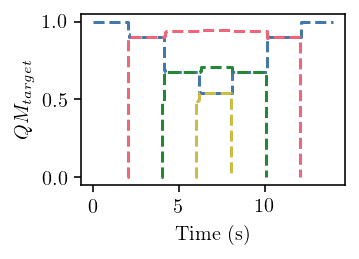

In [15]:
data = aggQM.xs("mean", level="name", axis=1)
# rearrange to have ncs14 first
cols = data.columns.tolist()
cols = [cols[1]] + [cols[0]] + cols[2:]
data = data[cols]

data.rename(columns={ "ncs14" : "1 $\\rightarrow$ 4",
                      "ncs12" : "1 $\\rightarrow$ 2",
                      "ncs23" : "2 $\\rightarrow$ 3",
                      "ncs34" : "3 $\\rightarrow$ 4"
                    }, inplace=True)

#display(data)

#fig, ax = plt.subplots(figsize=(8.5*cm,4.5*cm))
fig, ax = plt.subplots(figsize=(6.0*cm,4.0*cm))

for col in data.columns:
    plot_data = data[col].dropna()
    ax.plot(plot_data.index.values - 30, plot_data.values, label=col, drawstyle='steps-post', linestyle='dashed')

handles, labels = ax.get_legend_handles_labels()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0]), reverse=True))
#labels = np.vectorize(lambda x: '{0.magnitude:6.2f}{0.units:~}'.format((Q_(x) * ureg.second).to_compact()))(labels)

ncol=4
#legend = plot.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
#legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
#align_legend_labels(legend, ncol)

ax.set_xlabel('Time (s)')
ax.set_ylabel('$QM_{target}$')

plt.savefig(plot_prefix + '4flows_qm.pdf', bbox_inches='tight')
plt.show()

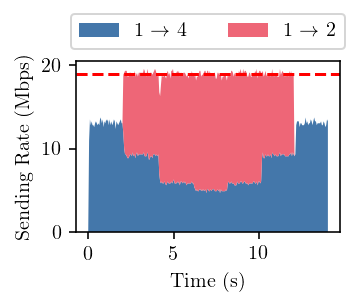

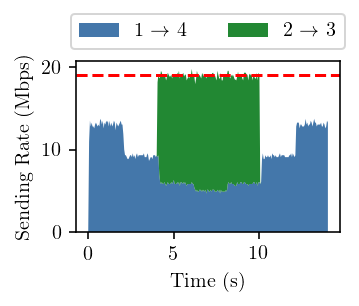

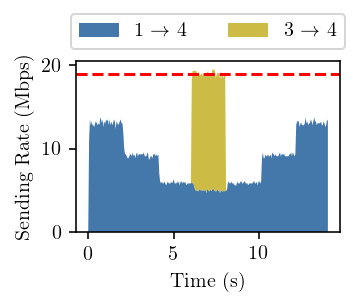

In [16]:
data = pd.DataFrame(aggRate.xs(0, level="name", axis=1))
pairings = [
    (1, "12", ["ncs14", "ncs12"]),
    (2, "23", ["ncs14", "ncs23"]),
    (3, "34", ["ncs14", "ncs34"]),
]

#display(data)

for pair in pairings:
    subset = data[pair[2]]
    subset = subset.rename(columns={"ncs14" : "1 $\\rightarrow$ 4",
                                    "ncs12" : "1 $\\rightarrow$ 2",
                                    "ncs23" : "2 $\\rightarrow$ 3",
                                    "ncs34" : "3 $\\rightarrow$ 4"})
    
    plot, ax = plt.subplots(figsize=(6.0*cm,4.0*cm))

    #for col in data.columns:
    #    plot_data = data[col].dropna()
    #    ax.stackplot(plot_data.index.values - 30, plot_data.values / 10**6#), label=col)
    ax.hlines(19, 0, 1, transform=ax.get_yaxis_transform(), linestyles='dashed', colors='r')
    ax.stackplot(subset.index.values - 30, subset.values.T / 10**6, labels=subset.columns, colors=[colormap[0], colormap[pair[0]]])

    handles, labels = ax.get_legend_handles_labels()
    #labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0]), reverse=True))
    #labels = np.vectorize(lambda x: '{0.magnitude:6.2f}{0.units:~}'.format((Q_(x) * ureg.second).to_compact()))(labels)

    #ncol=4
    #legend = plot.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
    legend = ax.legend(handles, labels, loc='lower center', bbox_to_anchor= (0.5, 1.01), ncol=2)
    #align_legend_labels(legend, ncol)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Sending Rate (Mbps)')
    #ax.set_xlim(3.9,4.3)

    plt.savefig(plot_prefix + '4flows_rate_' + pair[1] + '.pdf', bbox_inches='tight')
    plt.show()

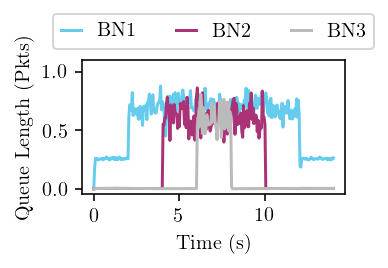

In [17]:
data = time_series_queue.xs("sum", level="name", axis=1)

#display(data)

data = data.rename(columns={"ic1" : "BN1",
                            "ic2" : "BN2",
                            "ic3" : "BN3"})

#plot, ax = plt.subplots(figsize=(8.5*cm,4.5*cm))
#fig, ax = plt.subplots(figsize=(4.0*cm,4.5*cm))
#fig, ax = plt.subplots(figsize=(6.0*cm,3.65*cm))
fig, ax = plt.subplots(figsize=(6.0*cm,3.125*cm))

for i in range(0,4):
    ax.plot([], [])

for col in data.columns:
    plot_data = data[col].dropna()
    ax.plot(plot_data.index.values - 30, plot_data.values, label=col)

handles, labels = ax.get_legend_handles_labels()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0]), reverse=True))
#labels = np.vectorize(lambda x: '{0.magnitude:6.2f}{0.units:~}'.format((Q_(x) * ureg.second).to_compact()))(labels)

#ncol=4
#legend = plot.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
#legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5), handlelength=1)
legend = ax.legend(handles, labels, loc='lower center', bbox_to_anchor= (0.5, 1.01), ncol=3, handlelength=1)
#align_legend_labels(legend, ncol)

ax.set_ylim(top=1.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Queue Length (Pkts)')

plt.savefig(plot_prefix + '4flows_queue.pdf', bbox_inches='tight')
plt.show()

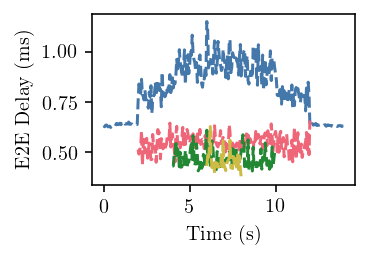

In [18]:
data = aggDelay.xs("mean", level="name", axis=1)

def rearrangeNcs(df):
    # rearrange to have ncs14 first
    cols = df.columns.tolist()
    cols = [cols[1]] + [cols[0]] + cols[2:]
    return df[cols]

data = rearrangeNcs(data)

labelMap = { "ncs14" : "1 $\\rightarrow$ 4",
             "ncs12" : "1 $\\rightarrow$ 2",
             "ncs23" : "2 $\\rightarrow$ 3",
             "ncs34" : "3 $\\rightarrow$ 4"
           }

#display(data)

#fig, ax = plt.subplots(figsize=(8.5*cm,4.5*cm))
fig, ax = plt.subplots(figsize=(6.0*cm,4.0*cm))

for i,col in enumerate(data.columns):
    plot_data = data[col].dropna()
    ax.plot(plot_data.index.values - 30, plot_data.values * 1000, label=labelMap[col], linestyle='dashed')

handles, labels = ax.get_legend_handles_labels()
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: float(t[0]), reverse=True))
#labels = np.vectorize(lambda x: '{0.magnitude:6.2f}{0.units:~}'.format((Q_(x) * ureg.second).to_compact()))(labels)

ncol=4
#legend = plot.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
#legend = ax.legend(handles, labels, loc='center left', bbox_to_anchor= (1.01, 0.5))
#align_legend_labels(legend, ncol)

ax.set_xlabel('Time (s)')
ax.set_ylabel('E2E Delay (ms)')
#ax.set_xlim(5.9,6.2)

plt.savefig(plot_prefix + '4flows_delay.pdf', bbox_inches='tight')
plt.show()